In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

Run1080_SP19_1139_generate.ipynb   Run1081_SP18_3323_generate.ipynb
Run1080_SP20_10838_generate.ipynb  Run1087_SP17_8693_generate.ipynb
Run1080_SP20_642_generate.ipynb    Run1087_SP18_8471_generate.ipynb
Run1080_SP21_213_generate.ipynb    Run1087_SP19_4061_generate.ipynb
Run1081_SP17_2566_generate.ipynb   Run1087_SP20_1098_generate.ipynb
/mnt/ufs18/home-144/dingjia5/projects/CosMx_kidney/benchmark_generation_scripts


### standard: fov in metadata_file, not Run1080_SP19_1139_fov_positions_file


# Transcript Data

In [4]:
import pandas as pd


In [5]:
gene_spatial = pd.read_csv('../Run1080_SP19_1139/Run1080_SP19_1139_tx_file.csv')
gene_spatial

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,8,0,-22408.427778,-160498.666667,3319.35,3568.000,8,TFEB,None
1,8,0,-24288.157778,-160615.130667,1439.62,3451.536,8,EPHB2,None
2,8,0,-24295.247778,-160598.299667,1432.53,3468.367,8,OLR1,None
3,8,0,-20733.967778,-160685.130667,4993.81,3381.536,8,IFNL3,None
4,8,0,-22780.247778,-160783.416667,2947.53,3283.250,8,GLUD1,None
...,...,...,...,...,...,...,...,...,...
22667575,25,3179,-36226.167778,-165525.888889,1951.61,13.000,1,RPL21,Cytoplasm
22667576,25,3179,-36238.717778,-165527.788889,1939.06,11.100,4,SQSTM1,Cytoplasm
22667577,25,3179,-36243.467778,-165525.228889,1934.31,13.660,4,CXCL16,Membrane
22667578,25,3179,-36231.577778,-165527.408889,1946.20,11.480,4,COL6A3,Nuclear


In [6]:
gene_spatial.shape

(22667580, 9)

In [7]:
min(gene_spatial["x_global_px"]), max(gene_spatial["x_global_px"])

(-49968.0944477778, -20266.5977777778)

In [8]:
min(gene_spatial["y_global_px"]), max(gene_spatial["y_global_px"])

(-165528.338888889, -121214.775)

In [9]:
min(gene_spatial["x_local_px"]), max(gene_spatial["x_local_px"])

(9.33333, 5461.64)

In [10]:
min(gene_spatial["y_local_px"]), max(gene_spatial["y_local_px"])

(10.2399999999998, 3638.4)

In [11]:
gene_spatial.loc[gene_spatial['fov']==8].shape

(1098742, 9)

In [12]:
gene_spatial.loc[gene_spatial['fov']==8].shape

(1098742, 9)

In [13]:
filtered_data_fov1_cell_ID_1 =  gene_spatial[(gene_spatial['fov']==8) & (gene_spatial['cell_ID']==1)]
filtered_data_fov1_cell_ID_1

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
195274,8,1,-24036.967778,-160453.433367,1690.81,3613.2333,8,GAS6,Nuclear
195275,8,1,-24035.917778,-160438.755567,1691.86,3627.9111,8,FZD4,Nuclear
195276,8,1,-24029.017778,-160466.712167,1698.76,3599.9545,8,KRT14,Nuclear
195277,8,1,-24057.797778,-160478.886667,1669.98,3587.7800,8,IFITM1,Cytoplasm
195278,8,1,-24061.027778,-160479.086667,1666.75,3587.5800,8,IGFBP7,Cytoplasm
...,...,...,...,...,...,...,...,...,...
195385,8,1,-24036.867778,-160480.488867,1690.91,3586.1778,1,HLA-A,Cytoplasm
195386,8,1,-24072.567778,-160476.366667,1655.21,3590.3000,4,GPX3,Cytoplasm
195387,8,1,-24065.227778,-160472.385467,1662.55,3594.2812,4,AZGP1,Cytoplasm
195388,8,1,-24071.387778,-160477.445267,1656.39,3589.2214,4,H4C3,Cytoplasm


In [14]:
gene_expression = pd.read_csv('../Run1080_SP19_1139/Run1080_SP19_1139_exprMat_file.csv')
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,8,0,77,135,68,129,338,57,102,91,...,64,73,56,64,127,82,95,111,75,95
1,8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,8,3,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,8,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61359,25,3175,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61360,25,3176,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61361,25,3177,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61362,25,3178,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
gene_expression.shape

(61364, 981)

In [16]:
cell_boundary = pd.read_csv('../Run1080_SP19_1139/Run1080_SP19_1139_metadata_file.csv')
cell_boundary


,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.G,Max.G,Mean.Y,Max.Y,Mean.R,Max.R,Mean.DAPI,Max.DAPI
0,8,1,5032,1.27,1690,3613,-24037.777778,-160453.666667,89,70,4413,14464,383,1851,44,6998,2,152,1543,12485
1,8,2,4826,1.41,1940,3614,-23787.777778,-160452.666667,96,68,2163,8644,745,6428,107,11940,4,244,1807,11088
2,8,3,4512,1.11,3510,3611,-22217.777778,-160455.666667,82,74,8020,54538,1308,6213,132,8215,97,639,292,11512
3,8,4,3188,1.00,1760,3615,-23967.777778,-160451.666667,67,67,1261,4042,1043,4976,72,553,5,227,1370,7270
4,8,5,8198,0.77,2356,3579,-23371.777778,-160487.666667,107,139,6676,18642,909,9441,50,11901,0,177,2049,18819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61341,25,3175,1574,1.78,5042,19,-33135.777778,-165519.888889,64,36,816,6223,35,1933,306,6960,11,281,1830,9596
61342,25,3176,529,2.24,3802,12,-34375.777778,-165526.888889,47,21,3365,5544,64642,65041,929,1344,191,518,1744,3767
61343,25,3177,2537,2.30,2393,20,-35784.777778,-165518.888889,85,37,1243,4022,1497,4867,1199,2191,485,1457,1198,7779
61344,25,3178,875,1.88,3762,14,-34415.777778,-165524.888889,47,25,3783,6241,61954,65012,967,1437,172,592,2117,7244


In [17]:
min(cell_boundary["CenterX_global_px"]), max(cell_boundary["CenterX_global_px"])

(-49968.7777777778, -20278.7777777778)

In [18]:
min(cell_boundary["CenterY_global_px"]), max(cell_boundary["CenterY_global_px"])

(-165529.888888889, -121222.0)

In [19]:
cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==8)]
cell_boundary_fov_1

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.G,Max.G,Mean.Y,Max.Y,Mean.R,Max.R,Mean.DAPI,Max.DAPI
0,8,1,5032,1.27,1690,3613,-24037.777778,-160453.666667,89,70,4413,14464,383,1851,44,6998,2,152,1543,12485
1,8,2,4826,1.41,1940,3614,-23787.777778,-160452.666667,96,68,2163,8644,745,6428,107,11940,4,244,1807,11088
2,8,3,4512,1.11,3510,3611,-22217.777778,-160455.666667,82,74,8020,54538,1308,6213,132,8215,97,639,292,11512
3,8,4,3188,1.00,1760,3615,-23967.777778,-160451.666667,67,67,1261,4042,1043,4976,72,553,5,227,1370,7270
4,8,5,8198,0.77,2356,3579,-23371.777778,-160487.666667,107,139,6676,18642,909,9441,50,11901,0,177,2049,18819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,8,3356,1078,2.46,4321,13,-21406.777778,-164053.666667,59,24,2821,9129,215,6350,122,9902,3,530,5020,11579
3356,8,3357,1851,1.86,2094,19,-23633.777778,-164047.666667,65,35,3776,9456,409,2294,191,7748,32,693,2666,12183
3357,8,3358,1776,2.09,3395,18,-22332.777778,-164048.666667,69,33,5613,13573,935,2770,53,6459,7,460,2003,13982
3358,8,3359,630,2.53,5298,11,-20429.777778,-164055.666667,48,19,2742,9950,1049,5048,19,204,10,462,2794,5785


In [20]:
type(cell_boundary_fov_1)
# cell_boundary_fov_1.to_csv('sample_fov2.csv')

pandas.core.frame.DataFrame

In [21]:
cell_boundary_fov_1.iloc[0]["CenterX_local_px"]

1690.0

In [22]:
cell_boundary_fov_1.iloc[0]["CenterY_local_px"]

3613.0

In [23]:
min(cell_boundary_fov_1["CenterX_local_px"]), max(cell_boundary_fov_1["CenterX_local_px"])

(22, 5449)

In [24]:
min(cell_boundary_fov_1["CenterY_local_px"]), max(cell_boundary_fov_1["CenterY_local_px"])

(11, 3627)

In [25]:
fov_position = pd.read_csv('../Run1080_SP19_1139/Run1080_SP19_1139_fov_positions_file.csv')


# fov_position = pd.read_csv('../Run1080_SP20_10838/Run1080_SP20_10838_fov_positions_file.csv')
fov_position

,fov,x_global_px,y_global_px
0,8,-25727.777778,-164066.666667
1,9,-28205.555556,-160400.000000
2,10,-30305.555556,-156716.666667
3,11,-32644.444444,-153016.666667
4,12,-34783.333333,-149322.222222
5,13,-40411.111111,-139694.444444
6,14,-42194.444444,-135977.777778
7,15,-43583.333333,-132288.888889
8,16,-45483.333333,-128583.333333
9,17,-47700.000000,-124850.000000


In [26]:
x_coordinate = [x / 10000 for x in list(fov_position["x_global_px"])]
x_coordinate

[-2.57277777777778,
 -2.82055555555556,
 -3.03055555555556,
 -3.26444444444444,
 -3.47833333333333,
 -4.04111111111111,
 -4.219444444444441,
 -4.35833333333333,
 -4.54833333333333,
 -4.77,
 -4.99777777777778,
 -4.7938888888888895,
 -4.607222222222219,
 -4.43222222222222,
 -4.259444444444441,
 -4.10166666666667,
 -3.93666666666667,
 -3.8177777777777804]

In [27]:
y_coordinate = [y / 10000 for y in list(fov_position["y_global_px"])]
y_coordinate

[-16.406666666666702,
 -16.04,
 -15.6716666666667,
 -15.301666666666701,
 -14.9322222222222,
 -13.9694444444444,
 -13.597777777777802,
 -13.2288888888889,
 -12.858333333333299,
 -12.485,
 -13.946111111111101,
 -14.3194444444444,
 -14.6905555555556,
 -15.063333333333299,
 -15.4355555555556,
 -15.8094444444444,
 -16.1811111111111,
 -16.5538888888889]

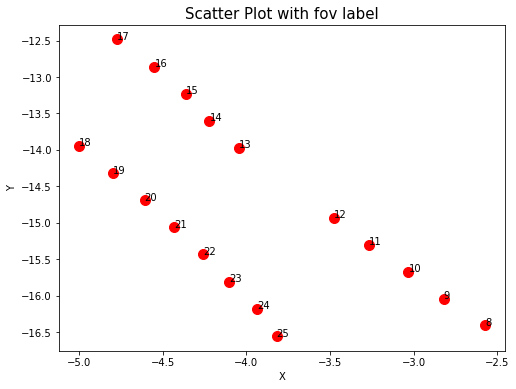

In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.randint(10, size=(5))
Y=np.random.randint(10, size=(5))

X = x_coordinate
Y = y_coordinate

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = list(fov_position["fov"])

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

In [29]:

fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates                                               

,fov,spot_id,x,y


In [30]:


def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] * 0.18 *1e-4
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] * 0.18 *1e-4
    
    return fov_spot_coordinates
    

In [31]:
coordinates = get_spot_x_y_range(0, 0, 8, fov_spot_coordinates)
coordinates

/tmp/ipykernel_5969/1954274113.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_5969/1954274113.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_5969/1954274113.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_5969/1954274113.py:27: FutureWarning: The frame.append method is deprecated and will be rem

,fov,spot_id,x,y
0,8.0,1.0,0.009850,0.057456
1,8.0,2.0,0.009850,0.041040
2,8.0,3.0,0.009850,0.024624
3,8.0,4.0,0.009850,0.008208
4,8.0,5.0,0.029549,0.057456
5,8.0,6.0,0.029549,0.041040
6,8.0,7.0,0.029549,0.024624
7,8.0,8.0,0.029549,0.008208
8,8.0,9.0,0.049248,0.057456
9,8.0,10.0,0.049248,0.041040


# Benchmark Generation

In [33]:
"""
1 μm(micrometer) = 1e-4 cm
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

'\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n'

In [34]:
"""
CosMx lung: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 
"""

'\nCosMx lung: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n'

In [35]:
"""
New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV
"""

'\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 196.992 um * 164.16 um = 32338.2067 um2\n3. In total: 20 spots / FOV\n'

In [36]:
"""
CosMx Kidey dataset:
Assume FOV size on kidney is 5472 x 3648 pixels.

so the pseudo spot still be: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um

"""

'\nCosMx Kidey dataset:\nAssume FOV size on kidney is 5472 x 3648 pixels.\n\nso the pseudo spot still be: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n\n'

In [37]:
"""
spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)

spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)
"""

'\nspot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)\n\nspot_gene_expression.csv (spot_id, gene1, gene2, gene3...)\n'

## 1. spot_fov_cellId_mapping.csv

In [32]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 1
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 2
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 3
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 4

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 5
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 6
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 7
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 8

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 9
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 10
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 11
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 12

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 13
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 14
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 15
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 16

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 17
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 18
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 19
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 20
        else:
            print("Wrong CenterX_local_px")
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)

    return data_result

        

In [33]:
data_final_result = pd.DataFrame(columns = [ 'fov', 'spot_id', 'cell_ID'])
data_final_result

,fov,spot_id,cell_ID


In [34]:
cell_boundary

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.G,Max.G,Mean.Y,Max.Y,Mean.R,Max.R,Mean.DAPI,Max.DAPI
0,8,1,5032,1.27,1690,3613,-24037.777778,-160453.666667,89,70,4413,14464,383,1851,44,6998,2,152,1543,12485
1,8,2,4826,1.41,1940,3614,-23787.777778,-160452.666667,96,68,2163,8644,745,6428,107,11940,4,244,1807,11088
2,8,3,4512,1.11,3510,3611,-22217.777778,-160455.666667,82,74,8020,54538,1308,6213,132,8215,97,639,292,11512
3,8,4,3188,1.00,1760,3615,-23967.777778,-160451.666667,67,67,1261,4042,1043,4976,72,553,5,227,1370,7270
4,8,5,8198,0.77,2356,3579,-23371.777778,-160487.666667,107,139,6676,18642,909,9441,50,11901,0,177,2049,18819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61341,25,3175,1574,1.78,5042,19,-33135.777778,-165519.888889,64,36,816,6223,35,1933,306,6960,11,281,1830,9596
61342,25,3176,529,2.24,3802,12,-34375.777778,-165526.888889,47,21,3365,5544,64642,65041,929,1344,191,518,1744,3767
61343,25,3177,2537,2.30,2393,20,-35784.777778,-165518.888889,85,37,1243,4022,1497,4867,1199,2191,485,1457,1198,7779
61344,25,3178,875,1.88,3762,14,-34415.777778,-165524.888889,47,25,3783,6241,61954,65012,967,1437,172,592,2117,7244


In [35]:
type(cell_boundary)

pandas.core.frame.DataFrame

In [36]:
fov_ids_lst = cell_boundary['fov'].unique()
fov_ids_lst

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25])

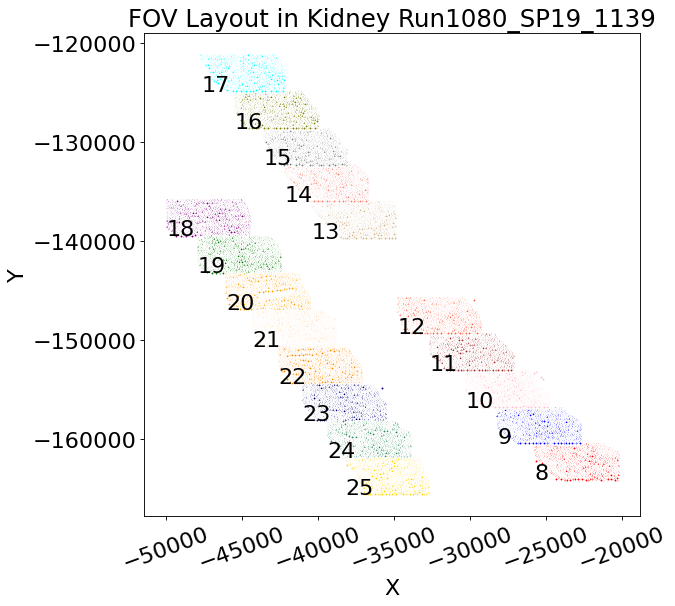

In [40]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

# plt.scatter(X,Y,s=10,color="red")
# plt.scatter(X_plus, Y_plus,s=10,color="red")
# plt.scatter(X_plus, Y,s=10,color="red")
# plt.scatter(X, Y_plus,s=10,color="red")

plt.xticks(fontsize=20, rotation=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Kidney Run1080_SP19_1139",fontsize=22)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.savefig("../../FOV_layout/kidney_Run1080_SP19_1139.png", format="png", bbox_inches="tight")
plt.show()


In [37]:
for fov_id in fov_ids_lst:
    print("fov_id:", fov_id, cell_boundary[(cell_boundary['fov']==fov_id)].shape)

fov_id: 8 (3360, 20)
fov_id: 9 (3429, 20)
fov_id: 10 (3228, 20)
fov_id: 11 (3110, 20)
fov_id: 12 (3104, 20)
fov_id: 13 (3560, 20)
fov_id: 14 (3467, 20)
fov_id: 15 (3617, 20)
fov_id: 16 (3661, 20)
fov_id: 17 (3446, 20)
fov_id: 18 (3514, 20)
fov_id: 19 (3811, 20)
fov_id: 20 (3126, 20)
fov_id: 21 (3770, 20)
fov_id: 22 (3182, 20)
fov_id: 23 (3565, 20)
fov_id: 24 (3217, 20)
fov_id: 25 (3179, 20)


In [38]:
cell_boundary[(cell_boundary['fov']==8)]["CenterX_global_px"].tolist()

[-24037.7777777778,
 -23787.7777777778,
 -22217.7777777778,
 -23967.7777777778,
 -23371.7777777778,
 -23267.7777777778,
 -24627.7777777778,
 -24932.7777777778,
 -22455.7777777778,
 -21665.7777777778,
 -24121.7777777778,
 -23314.7777777778,
 -22284.7777777778,
 -23158.7777777778,
 -23834.7777777778,
 -24613.7777777778,
 -23802.7777777778,
 -24034.7777777778,
 -21683.7777777778,
 -25132.7777777778,
 -22215.7777777778,
 -21824.7777777778,
 -23180.7777777778,
 -22242.7777777778,
 -24938.7777777778,
 -23990.7777777778,
 -22982.7777777778,
 -23910.7777777778,
 -23690.7777777778,
 -24597.7777777778,
 -22434.7777777778,
 -22052.7777777778,
 -24830.7777777778,
 -23143.7777777778,
 -23946.7777777778,
 -23879.7777777778,
 -22188.7777777778,
 -24970.7777777778,
 -24744.7777777778,
 -22291.7777777778,
 -21747.7777777778,
 -24906.7777777778,
 -25295.7777777778,
 -21886.7777777778,
 -23049.7777777778,
 -23184.7777777778,
 -25501.7777777778,
 -22489.7777777778,
 -23106.7777777778,
 -22430.7777777778,


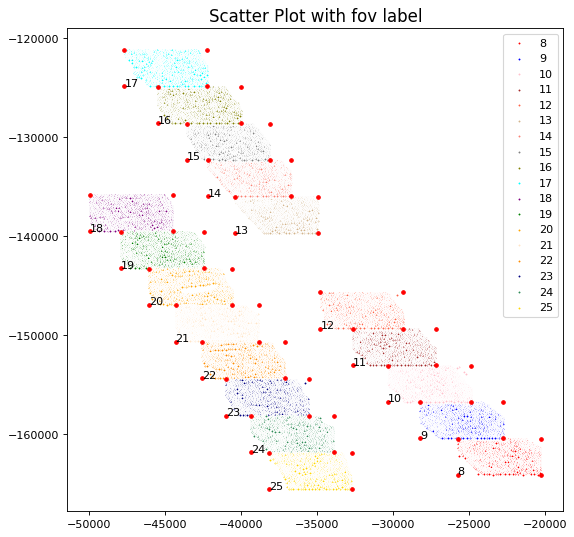

In [39]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", "gold", "teal"]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

plt.scatter(X,Y,s=10,color="red")
plt.scatter(X_plus, Y_plus,s=10,color="red")
plt.scatter(X_plus, Y,s=10,color="red")
plt.scatter(X, Y_plus,s=10,color="red")


plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))


plt.show()


In [41]:
fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_id)]
    print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)
#     print(data_final_result)
#     break

data_final_result

fov_ids_lst: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
fov_id: 8
cell_boundary_fov_without_spot_id: (3360, 20)
       fov  spot_id  cell_ID
0      8.0      8.0      1.0
1      8.0      8.0      2.0
2      8.0     16.0      3.0
3      8.0      8.0      4.0
4      8.0     12.0      5.0
...    ...      ...      ...
13372  8.0     13.0   3356.0
13373  8.0      5.0   3357.0
13374  8.0     13.0   3358.0
13375  8.0     17.0   3359.0
13376  8.0      9.0   3360.0

[13377 rows x 3 columns]


,fov,spot_id,cell_ID
0,8.0,8.0,1.0
1,8.0,8.0,2.0
2,8.0,16.0,3.0
3,8.0,8.0,4.0
4,8.0,12.0,5.0
...,...,...,...
13372,8.0,13.0,3356.0
13373,8.0,5.0,3357.0
13374,8.0,13.0,3358.0
13375,8.0,17.0,3359.0


In [101]:
data_final_result

,Unnamed: 0,fov,spot_id,cell_ID
0,0.0,8.0,8.0,1.0
1,1.0,8.0,8.0,2.0
2,2.0,8.0,16.0,3.0
3,3.0,8.0,8.0,4.0
4,4.0,8.0,12.0,5.0
...,...,...,...,...
122687,NaN,25.0,17.0,3175.0
122688,NaN,25.0,13.0,3176.0
122689,NaN,25.0,9.0,3177.0
122690,NaN,25.0,13.0,3178.0


In [102]:
data_final_result_sample = data_final_result[(data_final_result['fov']==8)]
data_final_result_sample

,Unnamed: 0,fov,spot_id,cell_ID
0,0.0,8.0,8.0,1.0
1,1.0,8.0,8.0,2.0
2,2.0,8.0,16.0,3.0
3,3.0,8.0,8.0,4.0
4,4.0,8.0,12.0,5.0
...,...,...,...,...
64701,NaN,8.0,13.0,3356.0
64702,NaN,8.0,5.0,3357.0
64703,NaN,8.0,13.0,3358.0
64704,NaN,8.0,17.0,3359.0


In [105]:
data_final_result.to_csv('../Run1080_SP19_1139/new/spot_fov_cellId_mapping.csv')

In [44]:
data_final_result

,fov,spot_id,cell_ID
0,8.0,8.0,1.0
1,8.0,8.0,2.0
2,8.0,16.0,3.0
3,8.0,8.0,4.0
4,8.0,12.0,5.0
...,...,...,...
61341,25.0,17.0,3175.0
61342,25.0,13.0,3176.0
61343,25.0,9.0,3177.0
61344,25.0,13.0,3178.0


## 2. spot_gene_expression.csv

In [45]:
data_final_result = pd.read_csv('../Run1080_SP19_1139/new/spot_fov_cellId_mapping.csv')
data_final_result

,Unnamed: 0,fov,spot_id,cell_ID
0,0,8.0,8.0,1.0
1,1,8.0,8.0,2.0
2,2,8.0,16.0,3.0
3,3,8.0,8.0,4.0
4,4,8.0,12.0,5.0
...,...,...,...,...
61341,61341,25.0,17.0,3175.0
61342,61342,25.0,13.0,3176.0
61343,61343,25.0,9.0,3177.0
61344,61344,25.0,13.0,3178.0


In [46]:
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,8,0,77,135,68,129,338,57,102,91,...,64,73,56,64,127,82,95,111,75,95
1,8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,8,3,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,8,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61359,25,3175,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61360,25,3176,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61361,25,3177,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61362,25,3178,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20'])
fov_spot_cells_stats


,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20


In [48]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0,
 'spot-id=10': 0,
 'spot-id=11': 0,
 'spot-id=12': 0,
 'spot-id=13': 0,
 'spot-id=14': 0,
 'spot-id=15': 0,
 'spot-id=16': 0,
 'spot-id=17': 0,
 'spot-id=18': 0,
 'spot-id=19': 0,
 'spot-id=20': 0}

In [49]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)



In [50]:
fov_spot_cells_stats.to_csv('../Run1080_SP19_1139/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20
0,8,3,82,156,176,155,202,195,181,199,...,213,197,164,186,165,189,189,203,199,89
1,9,28,178,207,184,192,175,213,191,220,...,181,192,192,174,197,189,207,156,185,33
2,10,20,158,236,189,205,121,167,183,175,...,155,177,182,202,181,230,182,201,100,18
3,11,40,152,183,180,222,184,143,149,158,...,150,215,188,180,152,192,174,177,98,20
4,12,88,133,148,145,182,94,142,165,170,...,168,177,178,205,221,208,173,188,121,44
5,13,0,15,114,238,92,210,198,253,225,...,220,221,220,183,201,181,157,191,199,225
6,14,0,28,139,167,167,225,186,228,241,...,213,198,181,211,195,207,148,195,202,128
7,15,35,109,173,192,220,203,186,213,251,...,182,207,212,202,207,211,189,227,151,41
8,16,82,165,230,201,228,224,180,183,173,...,182,192,217,282,181,183,238,192,112,30
9,17,1,96,130,215,126,213,195,191,195,...,225,248,180,188,160,230,173,179,163,101


In [51]:
data_final_result[(data_final_result['fov']==fov_id)]

,Unnamed: 0,fov,spot_id,cell_ID
58167,58167,25.0,4.0,1.0
58168,58168,25.0,4.0,2.0
58169,58169,25.0,4.0,3.0
58170,58170,25.0,4.0,4.0
58171,58171,25.0,4.0,5.0
...,...,...,...,...
61341,61341,25.0,17.0,3175.0
61342,61342,25.0,13.0,3176.0
61343,61343,25.0,9.0,3177.0
61344,61344,25.0,13.0,3178.0


In [52]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = (gene_expression.columns)[2:].tolist()
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BATF3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA'

In [53]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23


In [54]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = (fov_expression.columns)[2:].tolist()
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
                
#         for gene_name in genes_lst:
#             gene_count_dic[gene_name] = gene_count_dic[gene_name] + cell_gene_expression[gene_name]
    
    return cell_gene_expression_total
    
    
    
        
    
    

In [55]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
    
    
  

fov_id: 8
fov_id: 9
fov_id: 10
fov_id: 11
fov_id: 12
fov_id: 13
fov_id: 14
fov_id: 15
fov_id: 16
fov_id: 17
fov_id: 18
fov_id: 19
fov_id: 20
fov_id: 21
fov_id: 22
fov_id: 23
fov_id: 24
fov_id: 25


In [56]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,8,1,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,8,2,3,10,7,8,20,0,6,10,...,5,4,6,3,2,4,4,5,3,4
2,8,3,10,19,10,8,50,9,9,11,...,5,6,6,8,7,7,2,7,5,11
3,8,4,7,22,11,16,28,1,7,14,...,10,8,6,3,8,5,4,11,4,9
4,8,5,12,14,15,5,29,5,7,8,...,9,3,3,5,6,5,7,7,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,25,16,15,28,20,21,75,14,25,18,...,9,5,10,11,13,8,10,13,10,13
356,25,17,19,42,21,22,58,19,10,19,...,7,10,14,11,12,18,15,12,13,16
357,25,18,11,22,17,16,46,6,11,13,...,7,5,3,10,10,10,13,10,6,4
358,25,19,9,10,9,20,60,12,7,15,...,2,2,3,7,7,6,7,15,7,8


In [57]:
spot_gene_expression.to_csv('../Run1080_SP19_1139/new/spot_gene_expression.csv')

## 3. Ground Truth

In [66]:
CosMx_cell_type = pd.read_csv('../cell_type/annot.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,1,c_1_13_1,13,4002,1.60,88,55,11986,28069,5650,...,20,1.301030,0.006710,False,#4A5202FF,NotDet,5,0.05,III,Podocyte
1,2,c_1_13_2,13,5472,1.90,116,61,15688,33560,194,...,632,2.800717,0.212033,False,#050300FF,a,7,0.50,III,Proliferating.Proximal.Tubule
2,3,c_1_13_3,13,4925,1.42,95,67,15469,44395,254,...,271,2.432969,0.090919,False,#0F0400FF,a,4,0.20,III,Distinct.proximal.tubule.2
3,4,c_1_13_4,13,8394,1.33,124,93,14543,63023,368,...,555,2.744293,0.186200,False,#050504FF,a,7,0.35,III,Distinct.proximal.tubule.1
4,5,c_1_13_5,13,2147,1.66,68,41,10302,30099,3765,...,163,2.212188,0.054686,False,#023700FF,T CD4 memory,7,0.15,III,Pelvic.epithelium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296833,296834,c_10_13_3887,13,1292,2.76,69,25,16245,58372,60969,...,67,1.826075,0.022478,False,#B3FFC9FF,d,2,0.00,III,Connecting.tubule
296834,296835,c_10_13_3888,13,2381,3.00,96,32,15011,32146,545,...,34,1.531479,0.011407,False,#090816FF,b,5,0.00,III,Fibroblast
296835,296836,c_10_13_3889,13,2543,2.27,84,37,16767,58501,31444,...,75,1.875061,0.025162,False,#85FFFFFF,d,2,0.00,III,Connecting.tubule
296836,296837,c_10_13_3890,13,1630,1.91,65,34,18983,30878,1379,...,25,1.397940,0.008387,False,#4E146EFF,b,5,0.00,III,Myofibroblast


In [67]:
set(CosMx_cell_type["fov"].tolist())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

In [68]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_1 = CosMx_cell_type.iloc[sample_1_index_lst]
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
89951,89952,c_5_8_1,8,5032,1.27,89,70,4413,14464,383,...,116,2.064458,0.038918,False,#330604FF,e,3,0.00,IV,Distinct.proximal.tubule.2
89952,89953,c_5_8_2,8,4826,1.41,96,68,2163,8644,745,...,246,2.390935,0.082532,False,#7B0B08FF,e,1,0.05,IV,Distinct.proximal.tubule.1
89953,89954,c_5_8_3,8,4512,1.11,82,74,8020,54538,1308,...,138,2.139879,0.046298,False,#9813C5FF,e,9,0.15,IV,Proximal.tubule
89954,89955,c_5_8_4,8,3188,1.00,67,67,1261,4042,1043,...,208,2.318063,0.069783,False,#530F0AFF,e,1,0.05,IV,Proximal.tubule
89955,89956,c_5_8_5,8,8198,0.77,107,139,6676,18642,909,...,327,2.514548,0.109707,False,#3A0D00FF,f,2,0.05,IV,Thick.ascending.limb.of.Loop.of.Henle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151019,151020,c_5_25_3173,25,1490,2.19,68,31,1835,4472,1976,...,97,1.986772,0.032543,False,#FF1DFFFF,e,1,0.00,IV,Proliferating.Proximal.Tubule
151020,151021,c_5_25_3174,25,1351,3.39,78,23,3829,7451,59711,...,58,1.763428,0.019459,False,#FFFFF8FF,d,2,0.00,IV,Principal.cell
151021,151022,c_5_25_3175,25,1574,1.78,64,36,816,6223,35,...,23,1.361728,0.007716,False,#FF0116FF,fibroblast,8,0.00,IV,Myofibroblast
151022,151023,c_5_25_3177,25,2537,2.30,85,37,1243,4022,1497,...,30,1.477121,0.010065,False,#FF16FFFF,e,5,0.00,IV,Proximal.tubule


In [69]:
CosMx_cell_type_sample_1.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,89952,c_5_8_1,8,5032,1.27,89,70,4413,14464,383,...,116,2.064458,0.038918,False,#330604FF,e,3,0.00,IV,Distinct.proximal.tubule.2
1,89953,c_5_8_2,8,4826,1.41,96,68,2163,8644,745,...,246,2.390935,0.082532,False,#7B0B08FF,e,1,0.05,IV,Distinct.proximal.tubule.1
2,89954,c_5_8_3,8,4512,1.11,82,74,8020,54538,1308,...,138,2.139879,0.046298,False,#9813C5FF,e,9,0.15,IV,Proximal.tubule
3,89955,c_5_8_4,8,3188,1.00,67,67,1261,4042,1043,...,208,2.318063,0.069783,False,#530F0AFF,e,1,0.05,IV,Proximal.tubule
4,89956,c_5_8_5,8,8198,0.77,107,139,6676,18642,909,...,327,2.514548,0.109707,False,#3A0D00FF,f,2,0.05,IV,Thick.ascending.limb.of.Loop.of.Henle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61068,151020,c_5_25_3173,25,1490,2.19,68,31,1835,4472,1976,...,97,1.986772,0.032543,False,#FF1DFFFF,e,1,0.00,IV,Proliferating.Proximal.Tubule
61069,151021,c_5_25_3174,25,1351,3.39,78,23,3829,7451,59711,...,58,1.763428,0.019459,False,#FFFFF8FF,d,2,0.00,IV,Principal.cell
61070,151022,c_5_25_3175,25,1574,1.78,64,36,816,6223,35,...,23,1.361728,0.007716,False,#FF0116FF,fibroblast,8,0.00,IV,Myofibroblast
61071,151023,c_5_25_3177,25,2537,2.30,85,37,1243,4022,1497,...,30,1.477121,0.010065,False,#FF16FFFF,e,5,0.00,IV,Proximal.tubule


In [70]:

for i in CosMx_cell_type_sample_1.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_1.at[i,'cell_ID']= int(CosMx_cell_type_sample_1.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,89952,1,8,5032,1.27,89,70,4413,14464,383,...,116,2.064458,0.038918,False,#330604FF,e,3,0.00,IV,Distinct.proximal.tubule.2
1,89953,2,8,4826,1.41,96,68,2163,8644,745,...,246,2.390935,0.082532,False,#7B0B08FF,e,1,0.05,IV,Distinct.proximal.tubule.1
2,89954,3,8,4512,1.11,82,74,8020,54538,1308,...,138,2.139879,0.046298,False,#9813C5FF,e,9,0.15,IV,Proximal.tubule
3,89955,4,8,3188,1.00,67,67,1261,4042,1043,...,208,2.318063,0.069783,False,#530F0AFF,e,1,0.05,IV,Proximal.tubule
4,89956,5,8,8198,0.77,107,139,6676,18642,909,...,327,2.514548,0.109707,False,#3A0D00FF,f,2,0.05,IV,Thick.ascending.limb.of.Loop.of.Henle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61068,151020,3173,25,1490,2.19,68,31,1835,4472,1976,...,97,1.986772,0.032543,False,#FF1DFFFF,e,1,0.00,IV,Proliferating.Proximal.Tubule
61069,151021,3174,25,1351,3.39,78,23,3829,7451,59711,...,58,1.763428,0.019459,False,#FFFFF8FF,d,2,0.00,IV,Principal.cell
61070,151022,3175,25,1574,1.78,64,36,816,6223,35,...,23,1.361728,0.007716,False,#FF0116FF,fibroblast,8,0.00,IV,Myofibroblast
61071,151023,3177,25,2537,2.30,85,37,1243,4022,1497,...,30,1.477121,0.010065,False,#FF16FFFF,e,5,0.00,IV,Proximal.tubule


In [71]:
sample_1_dic = {}
for key in CosMx_cell_type_sample_1["cell_type"].tolist():
    if key not in sample_1_dic:
        sample_1_dic[key] = 1
    else:
        sample_1_dic[key] = sample_1_dic[key] + 1

sample_1_dic


{'Distinct.proximal.tubule.2': 3457,
 'Distinct.proximal.tubule.1': 3248,
 'Proximal.tubule': 17958,
 'Thick.ascending.limb.of.Loop.of.Henle': 3419,
 'Descending.vasa.recta.endothelium': 940,
 'Proliferating.Proximal.Tubule': 3978,
 'Myofibroblast': 6015,
 'Ascending.vasa.recta.endothelium': 2828,
 'Connecting.tubule': 3765,
 'Peritubular.capillary.endothelium.1': 3442,
 'Fibroblast': 1746,
 'Epithelial.progenitor.cell': 3163,
 'Principal.cell': 1144,
 'mDC': 9,
 'Peritubular.capillary.endothelium.2': 297,
 'MNP.a.classical.monocyte.derived': 34,
 'Type.A.intercalated.cell': 882,
 'Glomerular.endothelium': 1117,
 'Type.B.intercalated.cell': 291,
 'MNP.c.dendritic.cell': 959,
 'MNP.b.non.classical.monocyte.derived': 83,
 'macrophage': 466,
 'Podocyte': 1484,
 'Indistinct.intercalated.cell': 3,
 'plasmablast': 204,
 'Pelvic.epithelium': 20,
 'pDC': 4,
 'T CD8 memory': 19,
 'neutrophil': 1,
 'B-cell': 49,
 'NK': 16,
 'T CD4 memory': 16,
 'mast': 2,
 'T CD4 naive': 3,
 'Treg': 8,
 'T CD8 n

In [73]:
CosMx_cell_type_sample_1_fov_1 = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==8)]
CosMx_cell_type_sample_1_fov_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,89952,1,8,5032,1.27,89,70,4413,14464,383,...,116,2.064458,0.038918,False,#330604FF,e,3,0.00,IV,Distinct.proximal.tubule.2
1,89953,2,8,4826,1.41,96,68,2163,8644,745,...,246,2.390935,0.082532,False,#7B0B08FF,e,1,0.05,IV,Distinct.proximal.tubule.1
2,89954,3,8,4512,1.11,82,74,8020,54538,1308,...,138,2.139879,0.046298,False,#9813C5FF,e,9,0.15,IV,Proximal.tubule
3,89955,4,8,3188,1.00,67,67,1261,4042,1043,...,208,2.318063,0.069783,False,#530F0AFF,e,1,0.05,IV,Proximal.tubule
4,89956,5,8,8198,0.77,107,139,6676,18642,909,...,327,2.514548,0.109707,False,#3A0D00FF,f,2,0.05,IV,Thick.ascending.limb.of.Loop.of.Henle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,93296,3354,8,2794,2.09,94,45,2313,13753,99,...,56,1.748188,0.018788,False,#340125FF,endothelial,3,0.00,IV,Peritubular.capillary.endothelium.2
3345,93297,3355,8,3852,1.94,95,49,3387,8084,1029,...,226,2.354108,0.075822,False,#550F23FF,e,1,0.00,IV,Proximal.tubule
3346,93298,3356,8,1078,2.46,59,24,2821,9129,215,...,26,1.414973,0.008723,False,#8D0306FF,e,5,0.00,IV,Distinct.proximal.tubule.2
3347,93299,3357,8,1851,1.86,65,35,3776,9456,409,...,56,1.748188,0.018788,False,#DC0641FF,b,5,0.00,IV,Distinct.proximal.tubule.1


In [74]:
cell_type_lst = set(CosMx_cell_type_sample_1['cell_type'].tolist())
print(len(cell_type_lst))
cell_type_lst

36


{'Ascending.vasa.recta.endothelium',
 'B-cell',
 'Connecting.tubule',
 'Descending.vasa.recta.endothelium',
 'Distinct.proximal.tubule.1',
 'Distinct.proximal.tubule.2',
 'Epithelial.progenitor.cell',
 'Fibroblast',
 'Glomerular.endothelium',
 'Indistinct.intercalated.cell',
 'MNP.a.classical.monocyte.derived',
 'MNP.b.non.classical.monocyte.derived',
 'MNP.c.dendritic.cell',
 'Myofibroblast',
 'NK',
 'Pelvic.epithelium',
 'Peritubular.capillary.endothelium.1',
 'Peritubular.capillary.endothelium.2',
 'Podocyte',
 'Principal.cell',
 'Proliferating.Proximal.Tubule',
 'Proximal.tubule',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Thick.ascending.limb.of.Loop.of.Henle',
 'Treg',
 'Type.A.intercalated.cell',
 'Type.B.intercalated.cell',
 'mDC',
 'macrophage',
 'mast',
 'neutrophil',
 'pDC',
 'plasmablast'}

In [75]:
sorted(cell_type_lst)

['Ascending.vasa.recta.endothelium',
 'B-cell',
 'Connecting.tubule',
 'Descending.vasa.recta.endothelium',
 'Distinct.proximal.tubule.1',
 'Distinct.proximal.tubule.2',
 'Epithelial.progenitor.cell',
 'Fibroblast',
 'Glomerular.endothelium',
 'Indistinct.intercalated.cell',
 'MNP.a.classical.monocyte.derived',
 'MNP.b.non.classical.monocyte.derived',
 'MNP.c.dendritic.cell',
 'Myofibroblast',
 'NK',
 'Pelvic.epithelium',
 'Peritubular.capillary.endothelium.1',
 'Peritubular.capillary.endothelium.2',
 'Podocyte',
 'Principal.cell',
 'Proliferating.Proximal.Tubule',
 'Proximal.tubule',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Thick.ascending.limb.of.Loop.of.Henle',
 'Treg',
 'Type.A.intercalated.cell',
 'Type.B.intercalated.cell',
 'mDC',
 'macrophage',
 'mast',
 'neutrophil',
 'pDC',
 'plasmablast']

In [76]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + sorted(cell_type_lst)
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


,fov,spot_id,Ascending.vasa.recta.endothelium,B-cell,Connecting.tubule,Descending.vasa.recta.endothelium,Distinct.proximal.tubule.1,Distinct.proximal.tubule.2,Epithelial.progenitor.cell,Fibroblast,...,Thick.ascending.limb.of.Loop.of.Henle,Treg,Type.A.intercalated.cell,Type.B.intercalated.cell,mDC,macrophage,mast,neutrophil,pDC,plasmablast


In [77]:
spot_celld_mapping = pd.read_csv('../Run1080_SP19_1139/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,fov,spot_id,cell_ID
0,0,8.0,8.0,1.0
1,1,8.0,8.0,2.0
2,2,8.0,16.0,3.0
3,3,8.0,8.0,4.0
4,4,8.0,12.0,5.0
...,...,...,...,...
61341,61341,25.0,17.0,3175.0
61342,61342,25.0,13.0,3176.0
61343,61343,25.0,9.0,3177.0
61344,61344,25.0,13.0,3178.0


In [78]:
type(spot_celld_mapping)

pandas.core.frame.DataFrame

In [79]:
CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,89952,1,8,5032,1.27,89,70,4413,14464,383,...,116,2.064458,0.038918,False,#330604FF,e,3,0.00,IV,Distinct.proximal.tubule.2
1,89953,2,8,4826,1.41,96,68,2163,8644,745,...,246,2.390935,0.082532,False,#7B0B08FF,e,1,0.05,IV,Distinct.proximal.tubule.1
2,89954,3,8,4512,1.11,82,74,8020,54538,1308,...,138,2.139879,0.046298,False,#9813C5FF,e,9,0.15,IV,Proximal.tubule
3,89955,4,8,3188,1.00,67,67,1261,4042,1043,...,208,2.318063,0.069783,False,#530F0AFF,e,1,0.05,IV,Proximal.tubule
4,89956,5,8,8198,0.77,107,139,6676,18642,909,...,327,2.514548,0.109707,False,#3A0D00FF,f,2,0.05,IV,Thick.ascending.limb.of.Loop.of.Henle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61068,151020,3173,25,1490,2.19,68,31,1835,4472,1976,...,97,1.986772,0.032543,False,#FF1DFFFF,e,1,0.00,IV,Proliferating.Proximal.Tubule
61069,151021,3174,25,1351,3.39,78,23,3829,7451,59711,...,58,1.763428,0.019459,False,#FFFFF8FF,d,2,0.00,IV,Principal.cell
61070,151022,3175,25,1574,1.78,64,36,816,6223,35,...,23,1.361728,0.007716,False,#FF0116FF,fibroblast,8,0.00,IV,Myofibroblast
61071,151023,3177,25,2537,2.30,85,37,1243,4022,1497,...,30,1.477121,0.010065,False,#FF16FFFF,e,5,0.00,IV,Proximal.tubule


In [80]:
cell_id_lst = CosMx_cell_type_sample_1["cell_ID"].tolist()
len(cell_id_lst)

61073

In [81]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        else:
            print("cell id not found in groud truth!!!")
        
    return cell_type_dic



In [82]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
print(fov_ids_lst)
fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==1)]
print("fov:", fov_data)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data)

[ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.]
fov: Empty DataFrame
Columns: [Unnamed: 0, fov, spot_id, cell_ID]
Index: []
spot: Empty DataFrame
Columns: [Unnamed: 0, fov, spot_id, cell_ID]
Index: []


In [83]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]

    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = (spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

In [84]:
fov_ids_lst


array([ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23., 24., 25.])

In [85]:
ground_truth_table

,fov,spot_id,Ascending.vasa.recta.endothelium,B-cell,Connecting.tubule,Descending.vasa.recta.endothelium,Distinct.proximal.tubule.1,Distinct.proximal.tubule.2,Epithelial.progenitor.cell,Fibroblast,...,Thick.ascending.limb.of.Loop.of.Henle,Treg,Type.A.intercalated.cell,Type.B.intercalated.cell,mDC,macrophage,mast,neutrophil,pDC,plasmablast
0,8.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,2.0,2.0,0.0,5.0,2.0,5.0,4.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,3.0,2.0,0.0,20.0,1.0,7.0,18.0,1.0,5.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8.0,4.0,5.0,0.0,16.0,2.0,5.0,15.0,5.0,6.0,...,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,5.0,13.0,0.0,1.0,6.0,5.0,5.0,1.0,9.0,...,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,25.0,16.0,9.0,0.0,0.0,4.0,8.0,14.0,4.0,5.0,...,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
356,25.0,17.0,8.0,0.0,5.0,3.0,13.0,18.0,5.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
357,25.0,18.0,7.0,1.0,0.0,5.0,7.0,15.0,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
358,25.0,19.0,11.0,0.0,2.0,0.0,13.0,11.0,3.0,12.0,...,8.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0


In [86]:
ground_truth_table.shape

(360, 38)

In [87]:
# lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
# lung13_ground_truth

In [88]:
# coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
# coumn_names

In [89]:
# first_n_column  = ground_truth_table.iloc[: , :2]
# first_n_column

In [90]:
ground_truth_table.to_csv('../Run1080_SP19_1139/new/ground_truth.csv')

## 4. Generate spot x, y coordiates

,fov,spot_id,x,y


In [110]:

def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] 
    
#     fov_spot_coordinates['x'] = fov_spot_coordinates['x'] * 0.18 *1e-4
#     fov_spot_coordinates['y'] = fov_spot_coordinates['y'] * 0.18 *1e-4
    
    
    return fov_spot_coordinates
    

In [111]:
fov_position

,fov,x_global_px,y_global_px
0,8,-25727.777778,-164066.666667
1,9,-28205.555556,-160400.000000
2,10,-30305.555556,-156716.666667
3,11,-32644.444444,-153016.666667
4,12,-34783.333333,-149322.222222
5,13,-40411.111111,-139694.444444
6,14,-42194.444444,-135977.777778
7,15,-43583.333333,-132288.888889
8,16,-45483.333333,-128583.333333
9,17,-47700.000000,-124850.000000


In [112]:
fov_position[fov_position['fov']==8]["x_global_px"].values[0]

-25727.7777777778

In [113]:
fov_lst = fov_position['fov'].tolist()
fov_lst

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [114]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates

,fov,spot_id,x,y


In [115]:
for fov_id in fov_lst:
    x_px = fov_position[fov_position['fov']==fov_id]["x_global_px"].values[0]
    y_px = fov_position[fov_position['fov']==fov_id]["y_global_px"].values[0]
    fov_spot_coordinates = get_spot_x_y_range(x_px, y_px, fov_id, fov_spot_coordinates)
fov_spot_coordinates

,fov,spot_id,x,y
0,8.0,1.0,-25180.577778,-160874.666667
1,8.0,2.0,-25180.577778,-161786.666667
2,8.0,3.0,-25180.577778,-162698.666667
3,8.0,4.0,-25180.577778,-163610.666667
4,8.0,5.0,-24086.177778,-160874.666667
...,...,...,...,...
355,25.0,16.0,-34347.377778,-165082.888889
356,25.0,17.0,-33252.977778,-162346.888889
357,25.0,18.0,-33252.977778,-163258.888889
358,25.0,19.0,-33252.977778,-164170.888889


In [116]:
fov_spot_coordinates.to_csv('../Run1080_SP19_1139/new/spot_location.csv')

## mapping between sample and real sample (should be done before 3. Groud Truth)

In [61]:
CosMx_cell_type = pd.read_csv('../cell_type/annot.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,1,c_1_13_1,13,4002,1.60,88,55,11986,28069,5650,...,20,1.301030,0.006710,False,#4A5202FF,NotDet,5,0.05,III,Podocyte
1,2,c_1_13_2,13,5472,1.90,116,61,15688,33560,194,...,632,2.800717,0.212033,False,#050300FF,a,7,0.50,III,Proliferating.Proximal.Tubule
2,3,c_1_13_3,13,4925,1.42,95,67,15469,44395,254,...,271,2.432969,0.090919,False,#0F0400FF,a,4,0.20,III,Distinct.proximal.tubule.2
3,4,c_1_13_4,13,8394,1.33,124,93,14543,63023,368,...,555,2.744293,0.186200,False,#050504FF,a,7,0.35,III,Distinct.proximal.tubule.1
4,5,c_1_13_5,13,2147,1.66,68,41,10302,30099,3765,...,163,2.212188,0.054686,False,#023700FF,T CD4 memory,7,0.15,III,Pelvic.epithelium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296833,296834,c_10_13_3887,13,1292,2.76,69,25,16245,58372,60969,...,67,1.826075,0.022478,False,#B3FFC9FF,d,2,0.00,III,Connecting.tubule
296834,296835,c_10_13_3888,13,2381,3.00,96,32,15011,32146,545,...,34,1.531479,0.011407,False,#090816FF,b,5,0.00,III,Fibroblast
296835,296836,c_10_13_3889,13,2543,2.27,84,37,16767,58501,31444,...,75,1.875061,0.025162,False,#85FFFFFF,d,2,0.00,III,Connecting.tubule
296836,296837,c_10_13_3890,13,1630,1.91,65,34,18983,30878,1379,...,25,1.397940,0.008387,False,#4E146EFF,b,5,0.00,III,Myofibroblast


In [62]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 11):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}


In [63]:
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == 5:
        sample_1_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    
    if fov_id not in sample_fov_count_dic[sample_id]:
        sample_fov_count_dic[sample_id].append(fov_id)
    
    if sample_id == 5:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 296838


In [64]:
print(sample_cell_count_dic)
print(sample_fov_count_dic)
print(fov_lst)
print(len(sample_1_index_lst))


{1: 28880, 2: 19616, 3: 28000, 4: 13455, 5: 61073, 6: 16474, 7: 12404, 8: 32534, 9: 34902, 10: 49500}
{1: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 2: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 3: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 4: [18, 19, 20, 21, 22, 23, 24, 25], 5: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 6: [1, 2, 3, 4, 5, 6, 7, 8], 7: [1, 2, 3, 4, 5, 6, 7], 8: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 9: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 10: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
61073


In [65]:
len(sample_1_index_lst)

61073